# DataFrame Operations

## About the Data
In this notebook, we will be working with 2 data sets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis)).
- daily weather data for NYC from the [National Centers for Environmental Information (NCEI) API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2).

*Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.*

## Background on the weather data

Data meanings:
- `AWND`: average wind speed
- `PRCP`: precipitation in millimeters
- `SNOW`: snowfall in millimeters
- `SNWD`: snow depth in millimeters
- `TMAX`: maximum daily temperature in Celsius
- `TMIN`: minimum daily temperature in Celsius

## Setup

In [1]:
import numpy as np
import pandas as pd

weather = pd.read_csv('data/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0017,0.0


In [2]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


## Arithmetic and statistics
We already saw that we can use mathematical operators like `+` and `/` with dataframes directly. However, we can also use methods, which allow us to specify the axis to perform the calculation over. By default this is per column. Let's find the z-scores for the volume traded and look at the days where this was more than 3 standard deviations from the mean:

In [3]:
fb.assign(
    abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')


,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


We can use `rank()` and `pct_change()` to see which days had the largest change in volume traded from the day before:

In [4]:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
        ascending=False
    )
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that Facebook's advertising is a key component of its business ([nearly 89% in 2017](https://www.investopedia.com/ask/answers/120114/how-does-facebook-fb-make-money.asp)), many shares were sold and the price dropped in panic:

In [5]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Throughout 2018, Facebook's stock price never had a low above $215:

In [6]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:

In [7]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

## Binning and thresholds
When working with the volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [8]:
(fb.volume.value_counts() > 1).sum()

0

We can use `pd.cut()` to create 3 bins of even an even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:

In [9]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

low     240
med       8
high      3
Name: volume, dtype: int64

In [10]:
fb[volume_binned == 'high'].sort_values(
    'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:

In [11]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:

In [12]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin. 

*Note: visualizations will be covered in chapters [5](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_05) and [6](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_05).*

In [13]:
import matplotlib.pyplot as plt

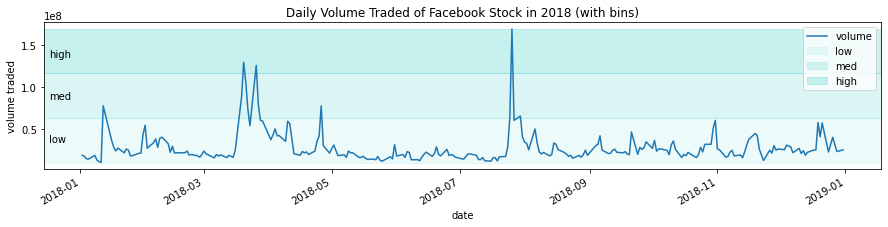

In [14]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
    ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
    
plt.ylabel('volume traded')
plt.legend()
plt.show()

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use `qcut()`. We will make 4 quartiles:

In [15]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

Notice the bins don't cover ranges of the same size anymore:

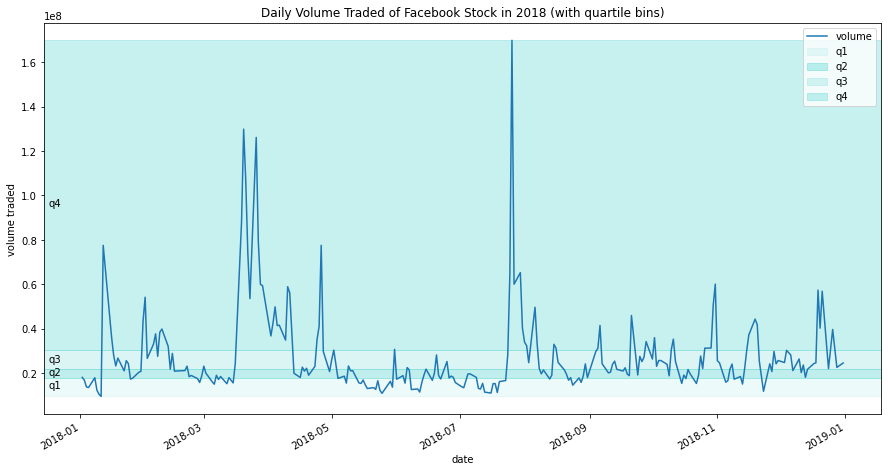

In [16]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
    
plt.ylabel('volume traded')
plt.legend()
plt.show()

Sometimes we don't want to make bins, but rather cap values at a threshold. Before we look at an example, let's pivot our weather data for the Central Park station:

In [17]:
central_park_weather = weather.query(
    'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

Say we don't care how much snow their was, just that it snowed in Central Park. However, we don't want to make a Boolean column since we need to preserve the data type of float. We can use `clip()` to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold. This means we can use `clip(0, 1)` to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park. Preserving the data type will save some work later on if we are building a model:

In [18]:
central_park_weather.SNOW.clip(0, 1).value_counts()

0.0    354
1.0     11
Name: SNOW, dtype: int64

*Note: the `clip()` method can also be called on the dataframe itself.*

## Applying Functions
We can use the `apply()` method to run the same operation on all columns (or rows) of the dataframe. Let's calculate the z-scores of the TMIN, TMAX, and PRCP observations in Central Park in October 2018:

In [19]:
oct_weather_z_scores = central_park_weather.loc[
    '2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,-3.010585e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,6.088320e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


October 27th rained much more than the rest of the days:

In [20]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


Indeed, this day was much higher than the rest:

In [21]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

When the function we want to apply isn't vectorized, we can:
- use `np.vectorize()` to vectorize it (similar to how `map()` works) and then use it with `apply()`
- use `applymap()` and pass it the non-vectorized function directly

Say we wanted to count the digits of the whole numbers for the Facebook data. `len()` is not vectorized:

In [22]:
import numpy as np

fb.apply(
    lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
    fb.applymap(lambda x: len(str(np.ceil(x))))
)

True

A simple operation of addition to each element in a series grows linearly in time complexity when using `iteritems()`, but stays near 0 when using vectorized operations. `iteritems()` and related methods should only be used if there is no vectorized solution:

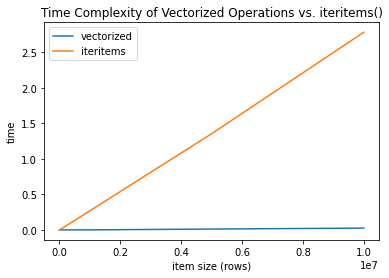

In [23]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.iteritems():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

## Window Calculations
*Consult the [understanding_window_calculations.ipynb notebook](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_04/understanding_window_calculations.ipynb) for interactive visualizations to help understand window calculations.*

The `rolling()` method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation function (sum here):

In [24]:
central_park_weather['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

/var/folders/rk/qwqd81bx00b1rl2fj8gy_vnc0000gn/T/ipykernel_17968/3761771204.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'].assign(


date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


We can also perform the rolling calculations on the entire dataframe at once. This will apply the same aggregation function to each column:

In [25]:
central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

/var/folders/rk/qwqd81bx00b1rl2fj8gy_vnc0000gn/T/ipykernel_17968/1136708426.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]


datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.900000,0.000000,0.0,0.0,24.400000,17.200000
2018-10-02,0.900000,8.750000,0.0,0.0,24.700000,17.750000
2018-10-03,0.966667,5.833333,0.0,0.0,24.233333,17.566667
2018-10-04,0.800000,6.166667,0.0,0.0,24.233333,17.200000
2018-10-05,1.033333,0.333333,0.0,0.0,23.133333,16.300000
2018-10-06,0.833333,0.333333,0.0,0.0,22.033333,16.300000
2018-10-07,1.066667,0.000000,0.0,0.0,22.600000,17.400000


We can use different aggregation functions per column if we use `agg()` instead. We pass in a dictionary mapping the column to the aggregation to perform on it:

In [26]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


Rolling calculations (`rolling()`) use a sliding window. Expanding calculations (`expanding()`) however grow in size. These are equivalent to cumulative aggregations like `cumsum()`; however, we can specify the minimum number of periods required to start calculating (default is 1):

In [27]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

Separate expanding aggregations per column. Note that `agg()` will accept numpy functions too:

In [28]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_expanding'
).sort_index(axis=1)

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


We can calculate the exponentially weighted moving average as follows. Note that `span` here is the periods to use:

In [29]:
fb.assign(
    close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


*Consult the [understanding_window_calculations.ipynb notebook](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_04/understanding_window_calculations.ipynb) for interactive visualizations to help understand window calculations.*

## Pipes
Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of if they are methods or functions:

We can pass any function that will accept the caller of `pipe()` as the first argument:

In [30]:
def get_info(df):
    return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())

fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
    == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

/var/folders/rk/qwqd81bx00b1rl2fj8gy_vnc0000gn/T/ipykernel_17968/3618091703.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
/var/folders/rk/qwqd81bx00b1rl2fj8gy_vnc0000gn/T/ipykernel_17968/3618091703.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))


True

For example, passing `pd.DataFrame.rolling` to `pipe()` is equivalent to calling `rolling()` directly on the dataframe, except we have more flexiblity to change this:

In [31]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

The pipe takes the function passed in and calls it with the object that called `pipe()` as the first argument. Positional and keyword arguments are passed down:

In [32]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

We can use a pipe to make a function that we can use for all our window calculation needs:

In [33]:
from window_calc import window_calc
window_calc??

We can use the same interface to calculate various window calculations now. Let's find the expanding median for the Facebook data:

In [34]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.580,177.5500,181.420,18151903.0
2018-01-03,179.78,183.180,179.4400,183.045,17519233.0
2018-01-04,181.88,184.780,181.3300,184.330,16886563.0
2018-01-05,183.39,185.495,182.7148,184.500,15383729.5
2018-01-08,184.90,186.210,184.0996,184.670,16886563.0


Using the exponentially weighted moving average requires we pass in a keyword argument:

In [35]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


With rolling calculations, we can pass in a positional argument for the window size:

In [36]:
window_calc(
    central_park_weather['2018-10'], 
    pd.DataFrame.rolling, 
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
    '3D'
).head()

/var/folders/rk/qwqd81bx00b1rl2fj8gy_vnc0000gn/T/ipykernel_17968/14855475.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'],


datatype,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0
